In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/Algorithms in Computational Biology/lab3

/content/drive/MyDrive/Colab Notebooks/Algorithms in Computational Biology/lab3




---



**KMP**

In [1]:
def get_pm_table(pattern):
  L = len(pattern)
  pm = [0]*L
  k = 0
  for q in range(1,L):
    if pattern[q] == pattern[k]:
      pm[q] = k + 1
      k = k + 1
    else:
      while k>0:
        k = pm[k-1]
        if pattern[q] == pattern[k]:
          pm[q] = k + 1
          k = k + 1
          break

      if k == 0:
        if pattern[q] == pattern[k]:
          pm[q] = k + 1
          k = k + 1
        else:
          pm[q] = 0
  return pm


get_pm_table("aabaaabaabaabb")

[0, 1, 0, 1, 2, 2, 3, 4, 5, 3, 4, 5, 3, 0]

In [ ]:
def KMP_search(pattern, string):
  m = len(pattern)
  n = len(string)

  pm = get_pm_table(pattern)
  i = 0 
  q = 0
  location = []

  trial = 0
  while i < n:
    if string[i] == pattern[q]:
      i = i + 1
      q = q + 1
      if q == m:
        pos = i - q
        q = pm[q-1]
        location.append(pos)
        print("Found ", string[pos:pos+m])
        return location
    else:
      if q == 0:
        i = i + 1
      else:
        q = pm[q-1]
  return location


string = "HERE IS A SIMPLE EXAMPLE"
pattern = "EXAMPLE"

KMP_search(pattern, string)

Found  EXAMPLE


[17]



---



**BM**

In [ ]:
def prepare_bad_character_table(pattern, string):
  bad_char_table = {}
  for i in range(len(string)):
    bad_char_table[string[i]] = -1

  for i in range(len(pattern)-1):
    bad_char_table[pattern[i]] = i

  return bad_char_table

string = "HERE IS A SIMPLE EXAMPLE"
pattern = "EXAMPLE"

bad_char_table = prepare_bad_character_table(pattern, string)
print(bad_char_table)

{'H': -1, 'E': 0, 'R': -1, ' ': -1, 'I': -1, 'S': -1, 'A': 2, 'M': 3, 'P': 4, 'L': 5, 'X': 1}


In [ ]:
def BM_search_with_badcharacter(pattern, string):
  m = len(pattern)
  n = len(string)

  bad_char_table = prepare_bad_character_table(pattern, string)
  i = m - 1

  location = []

  trial = 0 
  while i < n-m:
    j = m - 1
    while j >= 0 and string[i+j] == pattern[j]:
      j = j - 1

    # found the mismatch at i
    if j < 0:
      #found the pattern
      pos = i 
      location.append(pos+1)
      print("Found ", string[pos:pos+m])
      d = m + 1
      #return location
    else:
      d = max(1, j - bad_char_table[string[i+j]])

    i = i + d
  return location

string = "HERE IS A SIMPLE EXAMPLE"
pattern = "EXAMPLE"
BM_search_with_badcharacter(pattern, string)

BM_search_with_badcharacter("ATG","ACCGTAATGACTATGAA")

Found  ATG
Found  ATG


[7, 13]

**BM complete**

In [ ]:
import string

def z_array(s):
    """ Use Z algorithm (Gusfield theorem 1.4.1) to preprocess s """
    assert len(s) > 1
    z = [len(s)] + [0] * (len(s)-1)
    # Initial comparison of s[1:] with prefix
    for i in range(1, len(s)):
        if s[i] == s[i-1]:
            z[1] += 1
        else:
            break
    r, l = 0, 0
    if z[1] > 0:
        r, l = z[1], 1
    for k in range(2, len(s)):
        assert z[k] == 0
        if k > r:
            # Case 1
            for i in range(k, len(s)):
                if s[i] == s[i-k]:
                    z[k] += 1
                else:
                    break
            r, l = k + z[k] - 1, k
        else:
            # Case 2
            # Calculate length of beta
            nbeta = r - k + 1
            zkp = z[k - l]
            if nbeta > zkp:
                # Case 2a: Zkp wins
                z[k] = zkp
            else:
                # Case 2b: Compare characters just past r
                nmatch = 0
                for i in range(r+1, len(s)):
                    if s[i] == s[i - k]:
                        nmatch += 1
                    else:
                        break
                l, r = k, r + nmatch
                z[k] = r - k + 1
    return z


def n_array(s):
    """ Compile the N array (Gusfield theorem 2.2.2) from the Z array """
    return z_array(s[::-1])[::-1]


def big_l_prime_array(p, n):
    """ Compile L' array (Gusfield theorem 2.2.2) using p and N array.
        L'[i] = largest index j less than n such that N[j] = |P[i:]| """
    lp = [0] * len(p)
    for j in range(len(p)-1):
        i = len(p) - n[j]
        if i < len(p):
            lp[i] = j + 1
    return lp


def big_l_array(p, lp):
    """ Compile L array (Gusfield theorem 2.2.2) using p and L' array.
        L[i] = largest index j less than n such that N[j] >= |P[i:]| """
    l = [0] * len(p)
    l[1] = lp[1]
    for i in range(2, len(p)):
        l[i] = max(l[i-1], lp[i])
    return l


def small_l_prime_array(n):
    """ Compile lp' array (Gusfield theorem 2.2.4) using N array. """
    small_lp = [0] * len(n)
    for i in range(len(n)):
        if n[i] == i+1:  # prefix matching a suffix
            small_lp[len(n)-i-1] = i+1
    for i in range(len(n)-2, -1, -1):  # "smear" them out to the left
        if small_lp[i] == 0:
            small_lp[i] = small_lp[i+1]
    return small_lp


def good_suffix_table(p):
    """ Return tables needed to apply good suffix rule. """
    n = n_array(p)
    lp = big_l_prime_array(p, n)
    return lp, big_l_array(p, lp), small_l_prime_array(n)


def good_suffix_mismatch(i, big_l_prime, small_l_prime):
    """ Given a mismatch at offset i, and given L/L' and l' arrays,
        return amount to shift as determined by good suffix rule. """
    length = len(big_l_prime)
    assert i < length
    if i == length - 1:
        return 0
    i += 1  # i points to leftmost matching position of P
    if big_l_prime[i] > 0:
        return length - big_l_prime[i]
    return length - small_l_prime[i]


def good_suffix_match(small_l_prime):
    """ Given a full match of P to T, return amount to shift as
        determined by good suffix rule. """
    return len(small_l_prime) - small_l_prime[1]


def dense_bad_char_tab(p, amap):
    """ Given pattern string and list with ordered alphabet characters, create
        and return a dense bad character table.  Table is indexed by offset
        then by character. """
    tab = []
    nxt = [0] * len(amap)
    for i in range(0, len(p)):
        c = p[i]
        assert c in amap
        tab.append(nxt[:])
        nxt[amap[c]] = i+1
    return tab


class BoyerMoore(object):
    """ Encapsulates pattern and associated Boyer-Moore preprocessing. """
    
    def __init__(self, p, alphabet='ACGT'):
        self.p = p
        self.alphabet = alphabet
        # Create map from alphabet characters to integers
        self.amap = {}
        for i in range(len(self.alphabet)):
            self.amap[self.alphabet[i]] = i
        # Make bad character rule table
        self.bad_char = dense_bad_char_tab(p, self.amap)
        # Create good suffix rule table
        _, self.big_l, self.small_l_prime = good_suffix_table(p)
    
    def bad_character_rule(self, i, c):
        """ Return # skips given by bad character rule at offset i """
        assert c in self.amap
        ci = self.amap[c]
        assert i > (self.bad_char[i][ci]-1)
        return i - (self.bad_char[i][ci]-1)
    
    def good_suffix_rule(self, i):
        """ Given a mismatch at offset i, return amount to shift
            as determined by (weak) good suffix rule. """
        length = len(self.big_l)
        assert i < length
        if i == length - 1:
            return 0
        i += 1  # i points to leftmost matching position of P
        if self.big_l[i] > 0:
            return length - self.big_l[i]
        return length - self.small_l_prime[i]
    
    def match_skip(self):
        """ Return amount to shift in case where P matches T """
        return len(self.small_l_prime) - self.small_l_prime[1]

In [ ]:
def boyer_moore(p, p_bm, t):
    """ Do Boyer-Moore matching """
    i = 0
    occurrences = []
    while i < len(t) - len(p) + 1:
        shift = 1
        mismatched = False
        for j in range(len(p)-1, -1, -1):
            if p[j] != t[i+j]:
                skip_bc = p_bm.bad_character_rule(j, t[i+j])
                skip_gs = p_bm.good_suffix_rule(j)
                shift = max(shift, skip_bc, skip_gs)
                mismatched = True
                break
        if not mismatched:
            occurrences.append(i)
            skip_gs = p_bm.match_skip()
            shift = max(shift, skip_gs)
        i += shift
    return occurrences



---



**Ref seq prepare**

Access the chromosome Pt sequence

In [ ]:
# !wget ftp://ftp.ensemblgenomes.org/pub/plants/release-33/fasta/zea_mays/dna/Zea_mays.AGPv4.dna.chromosome.Pt.fa.gz
# !gzip -d Zea_mays.AGPv4.dna.chromosome.Pt.fa.gz

In [ ]:
! pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 4.1 MB/s 


In [ ]:
# use biopython to get the seq
from Bio import SeqIO
seq = ""
for seq_record in SeqIO.parse("Zea_mays.AGPv4.dna.chromosome.Pt.fa", "fasta"):
  seq = str(seq_record.seq)

print(seq)

GAAATACCCAATATCCTGTTGGAACAAGATATTGGGTATTTCCGGCTTTCCTTCCTTCAAAAATTCCTATATGTTTAGGAGAAAAACCTTATCCATTAAGGTAAGGAACTTCAAGAGCAGCTAGGTCTAGAGGGAAGTTGTGAGCATTACGTTCGTGCATTACCTCCATACCAAGATTAGCACGGTTGATGATATCAGCCCAAGTATTAATAACGCGACCTTGGCTATCAACTACAGATTGGTTGAAATTGAAACCATTTAGGTTGAATGCCATAGTACTAATACCTAAAGCAGTGAACCAGATCCCTACTACAGGCCAAGCAGCCAAGAAGAAGTGTAAAGAACGAGAATTGTTGAAACTAGCATATTGGAAGATTAATCGACCAAAATAACCGTGAGCAGCCACAATATTATAAGTCTCTTCTTCCTGACCAAATTTGTAACCCTCATTAGCAGACTCATTTTCAGTGGTTTCCCTGATCAAACTAGAGGTTACAAGGGAACCATGCATAGCACTGAATAGGGAACCGCCGAATACACCAGCTACACCTAACATGTGAAATGGATGCATAAGGATGTTGTGCTCTGCCTGGAATACAATCATAAAGTTGAAAGTACCAGATATTCCTAAAGGCATACCATCAGAGAAACTTCCTTGACCAATAGGGTAAATCAAGAAAACAGCAGTAGCAGCTGCAACAGGAGCTGAATATGCAACAGCAATCCAAGGGCGCATACCCAGACGGAAACTAAGTTCCCACTCACGACCCATATAACAAGCTACACCAAGTAAGAAGTGTAGAACAATTAGCTCATAAGGACCGCCATTGTATAACCATTCATCAACAGATGCAGCTTCCCAAATTGGGTAAAAATGCAACCCTATCGCCGCAGAAGTAGGAATAATAGCACCAGAGATAATATTGTTTCCATAAAGTAAAGAACCAGAAACAGGCTCACGAATACCATCAATATCTACTGGAGGAGCAGCGATGAAGGC

**Pattern prepare (Get specific column from Lab03_RNAseq_dataset.txt)**

Method 1 to get the reads:

In [ ]:
import csv
input_file = "Lab03_RNAseq_dataset.txt"
output_file = "pattern_seq.txt"
with open(input_file) as to_read:
  with open(output_file,"w") as tmp_file:
    reader = csv.reader(to_read, delimiter="\t")
    writer = csv.writer(tmp_file)
    desired_column = [1]
    for row in reader:
      myColumn  = list(row[i] for i in desired_column)
      writer.writerow(myColumn)

Method 2 to get the reads (Much easier to understand):

In [ ]:
text_string = []
with open(input_file) as ff:
  ss = ff.readlines()

for s in ss:
  text_string.append(s.split("\t")[1])

with open("pattern_seq2.txt",'w') as outf:
  outf.write('\n'.join(text_string)) # "\n" change line sign so each seq will be in a new line

ref:
1. https://docs.python.org/3/library/csv.html
2. https://stackoverflow.com/questions/33217277/read-and-export-a-single-column-from-a-tab-separated-file-in-python


In [ ]:
pattern = []
with open("pattern_seq.txt") as f:
  lines = f.readlines()
  for line in lines:
    pattern.append(line.rstrip()) # rstrip the "\n"

In [ ]:
pattern.remove('Read') #remove Read at index 0

In [ ]:
print(pattern[0] == "GATACAAAGTCTGTTTTTTCGA") 

True




---



**Run KMP algorithm**

In [ ]:
import time
with open("kmp_runtime.txt", "w") as kmp:
  for i in pattern:
    start = time.time()
    KMP_search(i, seq)
    end = time.time()
    total_time = end - start
    kmp.write(str(total_time)+'\n')
    
   


串流輸出內容已截斷至最後 5000 行。
Found  TTTCGTAGTTGCCGGAACTA
Found  TTTCGTAGTTGCCGGAACTA
Found  TCGTAGTTGCCGGAACTATG
Found  TATGGATCAGCAACTACCCCAAT
Found  TATTTGGGCCTACTCGTT
Found  ATTTGGGCCTACTCGTTAT
Found  GGCCTACTCGTTATCAGT
Found  ATCAGTGGGATCAGGGATA
Found  AGTGGGATCAGGGATACTTTCAGC
Found  GTGGGATCAGGGATACTTTCA
Found  GGGATCAGGGATACTTTCAGCAA
Found  GGGATCAGGGATACTTTCAGCAA
Found  GGGTTAGCCGAAAATCTTA
Found  AGCCGAAAATCTTAGTTTATC
Found  GGCAAAGGGGGGATTATTC
Found  GGGGATTATTCAGAGCAGGCT
Found  GGGGATTATTCAGAGCAGGCTC
Found  GGGATTATTCAGAGCAGGC
Found  GGGATTATTCAGAGCAGGCT
Found  GGGATTATTCAGAGCAGGC
Found  GAGCAGGCTCAATGGACAATG
Found  AATGGACAATGGGGATGGCA
Found  ATGGCATAGCTGTTGGATGGTT
Found  ATGGCATAGCTGTTGGATG
Found  ATGGCATAGCTGTTGGATGGTTA
Found  TGGCATAGCTGTTGGATGG
Found  CATAGCTGTTGGATGGTTA
Found  TTGGATGGTTAGGACATC
Found  AGAGATAAAGAAGGACGCGAGC
Found  AGAGATAAAGAAGGACGCGAGCTT
Found  AGAGATAAAGAAGGACGCGAGCTT
Found  GAGATAAAGAAGGACGCGAGCTT
Found  GAGATAAAGAAGGACGCGAGCTTT
Found  GAGATAAAGAAGGACGCGAGCT

**Run ExactMatch algorithm**

In [ ]:
import time
def  ExactMatch(text, pattern):
    for i in range((len(text) - len(pattern)+1)): 
      c = 0 #index for pattern
      while c < len(pattern):
        if text[i+c] != pattern[c]: # not match
          break

        c+=1 # match index +1 
      if c == len(pattern):
        print(i, end = ",")


with open("ExactMatch_runtime.txt", "w") as em:
  for i in pattern:
    start = time.time()
    print(ExactMatch(seq, i))
    end = time.time()
    total_time = end - start
    em.write(str(total_time)+'\n')


串流輸出內容已截斷至最後 5000 行。
71451,None
71451,None
71453,None
71476,None
71504,None
71505,None
71510,None
71522,None
71525,None
71526,None
71528,None
71528,None
71575,None
71580,None
71661,None
71669,None
71669,None
71670,None
71670,None
71670,None
71681,None
71691,None
71705,None
71705,None
71705,None
71706,None
71709,None
71717,None
71743,None
71743,None
71743,None
71744,None
71744,None
71744,None
71748,None
71749,None
71749,None
71753,None
71754,None
71763,None
71771,None
71792,None
71794,None
71795,None
71799,None
71801,None
71801,None
71924,None
71924,None
71949,None
71987,None
71992,None
71992,None
71992,None
71999,None
72004,None
72004,None
72012,None
72028,None
72030,None
72072,None
72074,None
72086,None
72090,None
72092,None
72092,None
72092,None
72093,None
72093,None
72094,None
72094,None
72096,None
72096,None
72102,None
72102,None
72112,None
72112,None
72112,None
72112,None
72128,None
72128,None
72145,None
72154,None
72155,None
72260,None
72376,None
72387,None
72399,None
72424,None


**Run BM algorithm_bad_char**

In [ ]:
with open("bm_runtime_bad_char.txt", "w") as bm:
  for i in pattern:
    start = time.time()
    BM_search_with_badcharacter(i, seq)
    end = time.time()
    total_time = end - start
    bm.write(str(total_time)+'\n')

串流輸出內容已截斷至最後 5000 行。
Found  TTTCGTAGTTGCCGGAACTA
Found  TTTCGTAGTTGCCGGAACTA
Found  TCGTAGTTGCCGGAACTATG
Found  TATGGATCAGCAACTACCCCAAT
Found  TATTTGGGCCTACTCGTT
Found  ATTTGGGCCTACTCGTTAT
Found  GGCCTACTCGTTATCAGT
Found  ATCAGTGGGATCAGGGATA
Found  AGTGGGATCAGGGATACTTTCAGC
Found  GTGGGATCAGGGATACTTTCA
Found  GGGATCAGGGATACTTTCAGCAA
Found  GGGATCAGGGATACTTTCAGCAA
Found  GGGTTAGCCGAAAATCTTA
Found  AGCCGAAAATCTTAGTTTATC
Found  GGCAAAGGGGGGATTATTC
Found  GGGGATTATTCAGAGCAGGCT
Found  GGGGATTATTCAGAGCAGGCTC
Found  GGGATTATTCAGAGCAGGC
Found  GGGATTATTCAGAGCAGGCT
Found  GGGATTATTCAGAGCAGGC
Found  GAGCAGGCTCAATGGACAATG
Found  AATGGACAATGGGGATGGCA
Found  ATGGCATAGCTGTTGGATGGTT
Found  ATGGCATAGCTGTTGGATG
Found  ATGGCATAGCTGTTGGATGGTTA
Found  TGGCATAGCTGTTGGATGG
Found  CATAGCTGTTGGATGGTTA
Found  TTGGATGGTTAGGACATC
Found  AGAGATAAAGAAGGACGCGAGC
Found  AGAGATAAAGAAGGACGCGAGCTT
Found  AGAGATAAAGAAGGACGCGAGCTT
Found  GAGATAAAGAAGGACGCGAGCTT
Found  GAGATAAAGAAGGACGCGAGCTTT
Found  GAGATAAAGAAGGACGCGAGCT

**Run BM algorithm_complete**

In [ ]:
with open("bm_runtime_complete.txt", "w") as bm_c:
  for i in pattern:
    start = time.time()
    p_bm = BoyerMoore(i, alphabet='ACGT')
    boyer_moore(i, p_bm, seq)
    end = time.time()
    total_time = end - start
    bm_c.write(str(total_time)+'\n')

In [ ]:
p_bm = BoyerMoore(pattern[0], alphabet='ACGT')
boyer_moore(pattern[0], p_bm, seq)

[1924]

In [ ]:
print(seq[1924:len(pattern[0])+1924] == pattern[0])

True




---



**Compare the distribution of running time**

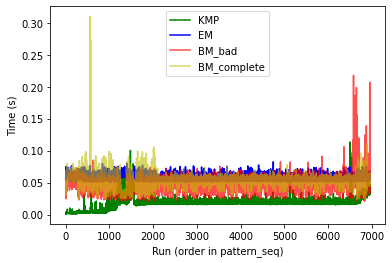

In [ ]:
import matplotlib.pyplot as plt
runs = []
kmp_time = []
em_time = []
bm_time_bad_char = []
bm_time_complete = []

for i in range(1,6955):
  runs.append(i)
with open("kmp_runtime.txt") as kmp:
  for row in kmp:
    kmp_time.append(float(row))


with open("ExactMatch_runtime.txt") as em:
  for row in em:
    em_time.append(float(row))

with open("bm_runtime_bad_char.txt") as bm_b:
  for row in bm_b:
    bm_time_bad_char.append(float(row))

with open("bm_runtime_complete.txt") as bm_c:
  for row in bm_c:
    bm_time_complete.append(float(row))

plt.plot(runs, kmp_time, label = "KMP", c = "g")
plt.plot(runs, em_time, label = "EM", c = "b")
plt.plot(runs, bm_time_bad_char, label = "BM_bad", c = "r",alpha = 0.7)
plt.plot(runs, bm_time_complete, label = "BM_complete", c = "y",alpha = 0.6)
plt.xlabel("Run (order in pattern_seq)")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

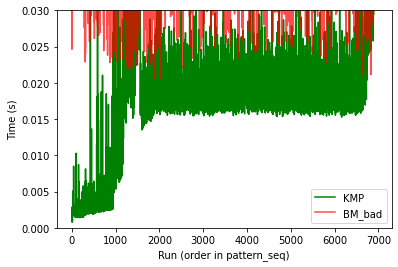

In [ ]:
plt.plot(runs, kmp_time, label = "KMP", c = "g")
plt.plot(runs, bm_time_bad_char, label = "BM_bad", c = "r",alpha = 0.7)
plt.xlabel("Run (order in pattern_seq)")
plt.ylabel("Time (s)")
plt.ylim([0.000,0.03])
plt.legend()
plt.show()

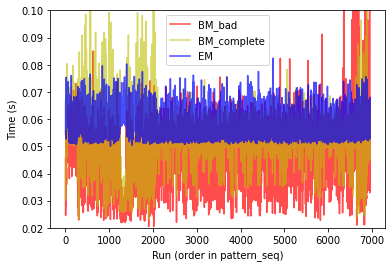

In [ ]:
plt.plot(runs, bm_time_bad_char, label = "BM_bad", c = "r",alpha = 0.7)
plt.plot(runs, bm_time_complete, label = "BM_complete", c = "y",alpha = 0.6)
plt.plot(runs, em_time, label = "EM", c = "b", alpha = 0.7)
plt.xlabel("Run (order in pattern_seq)")
plt.ylabel("Time (s)")
plt.ylim([0.02,0.1])
plt.legend()
plt.show()

In [ ]:
import pandas as pd
kmp_series = pd.Series(kmp_time)
kmp_series.describe()

count    6954.000000
mean        0.017215
std         0.008279
min         0.000784
25%         0.016374
50%         0.017316
75%         0.019093
max         0.113662
dtype: float64

In [ ]:
em_series = pd.Series(em_time)
em_series.describe()

count    6954.000000
mean        0.057371
std         0.004596
min         0.050102
25%         0.053493
50%         0.056578
75%         0.060005
max         0.082459
dtype: float64

In [ ]:
bm_bad_series = pd.Series(bm_time_bad_char)
bm_bad_series.describe()

count    6954.000000
mean        0.047191
std         0.011668
min         0.020471
25%         0.041554
50%         0.048943
75%         0.052368
max         0.217854
dtype: float64

In [ ]:
bm_complete_series = pd.Series(bm_time_complete)
bm_complete_series.describe()

count    6954.000000
mean        0.052503
std         0.010041
min         0.023136
25%         0.050014
50%         0.051622
75%         0.054429
max         0.310309
dtype: float64